# Report1  交通事故赔偿

##  

* 牛晓亮

 *  2020260244

##     

## 任务简介

>在交通摩擦（事故）发生后，理赔员会前往现场勘察、采集信息，这些信息往往影响着车主是否能够得到保险公司的理赔。训练集数据包括理赔人员在现场对该事故方采集的36条信息，信息已经被编码，以及该事故方最终是否获得理赔。我们的任务是根据这36条信息预测该事故方没有被理赔的概率。  
>这是一个典型的二元分类问题  
>数据的格式为csv格式  
>包含了20W条训练集和8W条测试集，其中由36项相关特征已经被编码  
>最终的目标是要输出每个测试样本未通过审核的概率，也就是Evaluation为1的概率。其中方法用PR-AUC进行评估  
>提高精度，精度越高，PR-AUC得分越高，面积越大  

##      

## 解决途径

### 选用模型

>在竞赛网上有两个标杆参考模型，一个是逻辑回归模型还有一个是随机森林模型，在这两个模型中随机森林的PR-AUC得分要明显高于逻辑回归模型的分数
>由于关于二元分类的训练模型较多，我这次在网上查阅相关资料将XGboost模型与随机森林模型做比较，在相同参数下得出最优模型

###  基础知识

####  1.混淆矩阵

>混淆矩阵是用来总结一个分类器结果的矩阵。对于k元分类，其实它就是一个k x k的表格，用来记录分类器的预测结果。
>对于最常见的二元分类来说，它的混淆矩阵是2乘2的，如下
>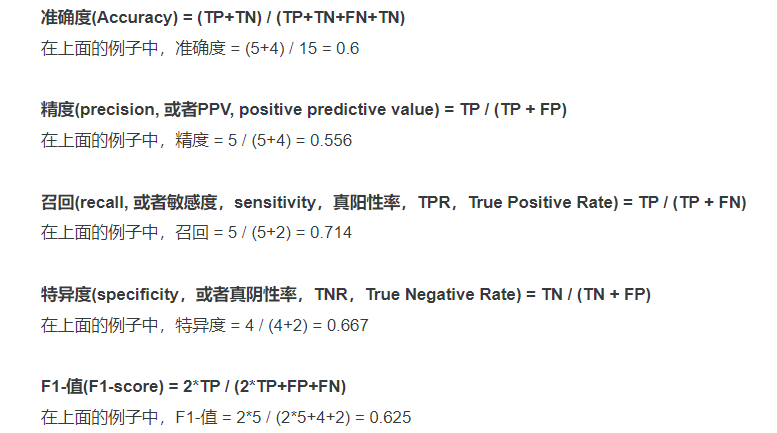
>TP = True Postive = 真阳性； FP = False Positive = 假阳性
>FN = False Negative = 假阴性； TN = True Negative = 真阴性
>对于一个15个样本进行预测，如下
>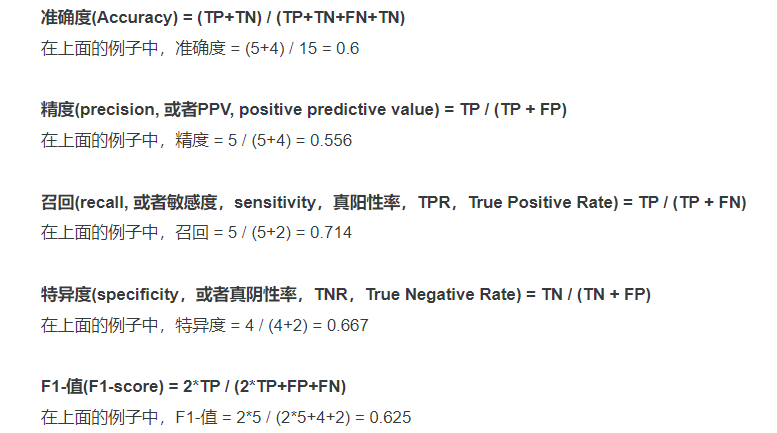
>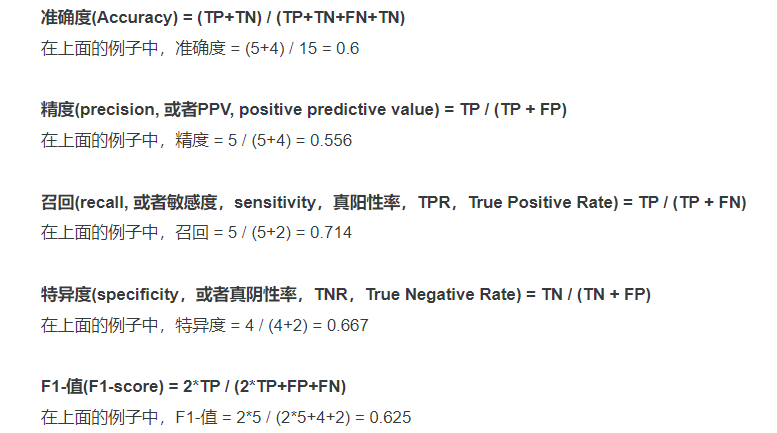

#### 2.PR-AUC

>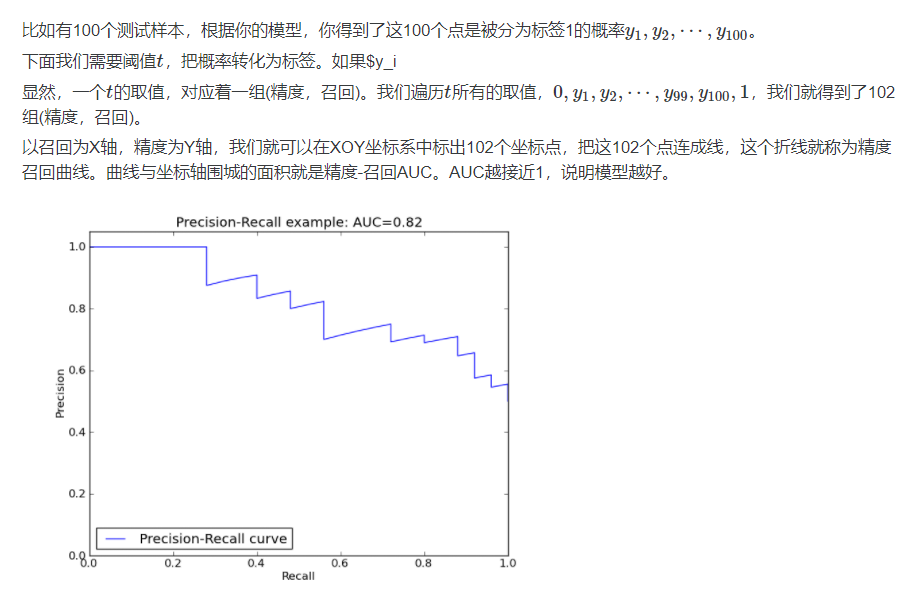

#### 3.PR-AUC计算方法

In [2]:
import numpy as np
from sklearn.metrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
y_predict = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_predict) 

0.8333333333333333

###  进行模型训练

####  1.随机森林模型

In [1]:
## 导入本次模型需要的包
from sklearn.ensemble import RandomForestClassifier 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 读取数据
train_acda = pd.read_csv('train.csv')
test_acda = pd.read_csv('test.csv')
submit_acda = pd.read_csv('sample_submit.csv')

In [3]:
#导入数据集
data = load_digits()
x = data.data
y = data.target

In [4]:
# 删除无关特征行（id）
train_acda.drop('CaseId', axis=1, inplace=True)
test_acda.drop('CaseId', axis=1, inplace=True)

In [5]:
#取出训练集
y_train = train_acda.pop('Evaluation')

In [9]:
# 建立随机森林模型
clf = RandomForestClassifier(random_state=66,n_estimators = 151,max_depth = 17,min_samples_leaf =1 ,min_samples_split =2 )
clf.fit(train_acda, y_train)
y_pred = clf.predict_proba(test_acda)[:, 1]

In [12]:
# 输出预测结果至my_RF_prediction.csv
submit_acda['Evaluation'] = y_pred
submit_acda.to_csv('my_RF_prediction3.csv', index=False)

>最终结果为0.8428

#### 2.Xgboost模型训练

In [1]:
#导入本次模型需要的包
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
#读取数据
train_acda = pd.read_csv('train.csv')
test_acda = pd.read_csv('test.csv')
submit_acda = pd.read_csv('sample_submit.csv')

In [3]:
#把非特征数据删除
train_acda.drop('CaseId', axis=1, inplace=True)
test_acda.drop('CaseId', axis=1, inplace=True)

In [4]:
#取出target，分类标签
train_label = train_acda['Evaluation']
train_acda.drop('Evaluation', axis=1, inplace=True)

In [5]:
#分割数据
train_acda1, test_acda1, train_label1 = train_acda.values, test_acda.values, train_label.values
X_train, X_test, y_train, y_test = train_test_split(train_acda1, 
                                                    train_label1,
                                                    test_size=0.3,
                                                    random_state=123457,
                                                   )

In [7]:
# 对max_depth和min_child_weight进行调优
#建立循环,查阅资料得到取值范围，在本次循环中步长取2
for depth in range(3,10,2):
    for weight in range(1,6,2):
        model = xgb.XGBClassifier(learning_rate =0.1,
                                  n_estimators=1000,
                                  max_depth=depth,
                                  min_child_weight=weight,
                                  gamma=0,
                                  subsample=0.8,
                                  colsample_bytree=0.8,
                                  objective= 'binary:logistic',
                                  nthread=4,
                                  scale_pos_weight=1,
                                  seed=27,
                                  )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print('accuracy:%2.f%%' % (accuracy * 100))
        from sklearn import metrics
        print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_pred))
        print(depth,weight,accuracy,metrics.roc_auc_score(y_test, y_pred))

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:93%
AUC Score (Train): 0.834778
3 1 0.9274166666666667 0.8347779790118091
[14:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834709
3 3 0.9273 0.8347085910139501
[14:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.837590
3 5 0.9270833333333334 0.8375897126314419
[14:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834094
5 1 0.92705 0.8340935667363638
[14:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



accuracy:93%
AUC Score (Train): 0.833999
5 3 0.9270333333333334 0.8339988658541965
[14:59:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834132
5 5 0.9269 0.8341315360628266
[15:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834145
7 1 0.9265666666666666 0.8341452554179845
[15:01:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



accuracy:93%
AUC Score (Train): 0.834018
7 3 0.9265666666666666 0.8340180729514174
[15:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833719
7 5 0.9266333333333333 0.8337185699917293


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:93%
AUC Score (Train): 0.833751
9 1 0.9258333333333333 0.8337514964441081
[15:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834490
9 3 0.9264333333333333 0.8344898964042263


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:93%
AUC Score (Train): 0.833136
9 5 0.9263666666666667 0.8331360272985426


>由以上结果可以看出当max_depth取3，min_child_weight取5时达到最佳优化

In [7]:
# 对gamma进行调优
#建立循环,查阅资料得到取值范围，在本次循环中步长取2
for gam in range(0,5):
    model = xgb.XGBClassifier(learning_rate =0.1,
                              n_estimators=1000,
                              max_depth=3,
                              min_child_weight=5,
                              gamma=gam/10,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27,
                              )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy:%2.f%%' % (accuracy * 100))
    from sklearn import metrics
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_pred))
    print(gam,accuracy,metrics.roc_auc_score(y_test, y_pred))


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:93%
AUC Score (Train): 0.837590
0 0.9270833333333334 0.8375897126314419
[11:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834041
1 0.9270333333333334 0.8340412600097188
[11:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834076
2 0.92695 0.8340764854651501
[11:26:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833563
3 0.9268 0.8335633307698223
[11:27:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.837368
4 0.9270666666666667 0.8373678292827074


>由以上结果说明，当gamma参数为0时能够输出较好的AUC的分，因此取0

In [6]:
# 对subsample 和 colsample_bytree 参数
#建立循环,查阅资料得到取值范围，在本次循环中步长取1
for subs in range(6,10,1):
    for bytree in range(6,10,1):
        model = xgb.XGBClassifier(learning_rate =0.1,
                                  n_estimators=1000,
                                  max_depth=3,
                                  min_child_weight=5,
                                  gamma=0,
                                  subsample=subs/10,
                                  colsample_bytree=bytree/10,
                                  objective= 'binary:logistic',
                                  nthread=4,
                                  scale_pos_weight=1,
                                  seed=27,
                                  )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print('accuracy:%2.f%%' % (accuracy * 100))
        from sklearn import metrics
        print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_pred))
        print(subs,bytree,accuracy,metrics.roc_auc_score(y_test, y_pred))

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:93%
AUC Score (Train): 0.833419
6 6 0.9267 0.8334190670320413
[11:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.832978
6 7 0.9266 0.8329780442056041
[11:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833746
6 8 0.92675 0.833745563834066
[11:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833970
6 9 0.9267 0.8339701910538319
[11:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833599
7 6 0.9267166666666666 0.8335985562252535
[11:57:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834451
7 7 0.9268666666666666 0.8344508641647601
[11:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834478
7 8 0.9269833333333334 0.8344778580070965
[11:59:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833388
7 9 0.9269333333333334 0.8333882664056698
[11:59:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833777
8 6 0.9270166666666667 0.8337769825054621
[12:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833884
8 7 0.9269833333333334 0.8338843398297837
[12:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.837590
8 8 0.9270833333333334 0.8375897126314419
[12:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834395
8 9 0.9272 0.8343947506540799
[12:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.835117
9 6 0.9274166666666667 0.8351171322559878
[12:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834809
9 7 0.9271833333333334 0.8348087796381807
[12:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.835173
9 8 0.9270833333333334 0.8351732457666678
[12:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.835727
9 9 0.9270166666666667 0.83572711365949


>由以上结果可知，当subsample和colsample_bytree都为0.8时，取得最优解

In [6]:
# 正则话参数
reg = [1e-5,1e-2,0.1,1,10,100]
for alpha in reg:
    model = xgb.XGBClassifier(learning_rate =0.1,
                              n_estimators=1000,
                              max_depth=3,
                              min_child_weight=5,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27,
                              reg_alpha=alpha,
                              )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy:%2.f%%' % (accuracy * 100))
    from sklearn import metrics
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_pred))
    print(alpha,accuracy,metrics.roc_auc_score(y_test, y_pred))

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:93%
AUC Score (Train): 0.837590
1e-05 0.9270833333333334 0.8375897126314419
[13:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.834021
0.01 0.927 0.8340214348674734
[13:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833894
0.1 0.927 0.8338942524009064
[13:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833800
1 0.9269833333333334 0.833799551518739
[13:54:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:93%
AUC Score (Train): 0.833311
10 0.9262333333333334 0.8333110916626952
[13:54:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy:92%
AUC Score (Train): 0.819310
100 0.9218666666666666 0.8193099701930366


>正则化参数调优可以看到相关性基本没有，这里在最终模型中选择无视这个参数

In [14]:
#根据优化选择模型，然后进行训练
model = xgb.XGBClassifier(learning_rate =0.1,
                          n_estimators=1000,
                          max_depth=3,
                          min_child_weight=5,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27,
                         )
model.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [15]:
#对测试集进行预测
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[14:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
#计算精确率
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:%2.f%%' % (accuracy * 100))

accuracy:93%


In [17]:
#AUC评价
from sklearn import metrics
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_pred))

AUC Score (Train): 0.837590


In [18]:
#对最终结果进行保存
def run_predict():
    y_pred_test = model.predict_proba(test_acda1)[:, 1]
    submitData = pd.read_csv('sample_submit.csv')
    submitData['Evaluation'] = y_pred_test
    submitData.to_csv("xgboost9.csv", index=False)

In [19]:
run_predict()

>查看部分结果

In [20]:
xgboost_acda = pd.read_csv('xgboost9.csv')

In [21]:
xgboost_acda.head()

,CaseId,Evaluation
0,200001,0.000039
1,200002,0.002388
2,200003,0.122887
3,200004,0.247544
4,200005,0.001071


##    

## 心得体会

>+我首先根据报告在交通赔偿事故竞赛网上阅读了相关基础知识，然后再取标杆模型中查看了两种模型，发现随机深林AUC评分较高
>+我决定去网上查看随机森林的知识，森林中的每棵树都是独立的，将若干个弱分类器的分类结果进行投票选择，从而组成一个 强分类器，bagging的代价是不用单棵决策树来做预测，具体哪个变量起 到重要作用变得未知，所以bagging改进了预测准确率
>+最后在网上看到了Xgboost模型，然后将Xgboost与随机森林模型（进行了参数优化后）进行了比较，发现Xgboost模型在AUC得分方面更具有优势
>+因为Xgboost参数太多，最后决定在max_depth和min_child_weight进行调优，查阅资料他们的经验范围为（3，10）和（1，6），因为参数量大，这里步长取2
>最后得到最佳取值（3，5）
>在其他参数调优过程发现原始参数数据得出就能得出最优解，因此保持不变
>最后将数据输出